# Data Exploration - Cluster-Busters
___

## Thema: Skin Cancer Classification 
### Original Challenge: https://challenge2018.isic-archive.com/
Data can be found here: https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000

Original Tasks to complete for the challenge: 
* Task 1: Lesion Segmentation  
* Task 2: Lesion Attribute Detection
* Task 3: Disease Classification

This Notebook focuses on Task 3 - the classification of the disease.
Convolutional Neural Networks are used to perform this task.
___
Index:
1. Imports
2. Loading Datasets
    1. Metadata Overview
    2. Picture Overview
3. Data Preprocessing
4. Models
5. Evaluation

# 1. Import Libraries

In [60]:
# Pandas to load data
import pandas as pd
# Numpy to handle certain data
import numpy as np
# Seaborn & Matplotlib for visualizing
import seaborn as sns
import matplotlib.pyplot as plt
# split data into training and testing data
from sklearn.model_selection import train_test_split
# keras imports for the dataset and building our neural network
import keras
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

# show result of model
from sklearn.metrics import classification_report

# Over- and Undersampler to create more equaly distributed data
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler

# Neural Network hyperparamter optimization
from hyperas import optim
from hyperopt import Trials, STATUS_OK, tpe



# 2. Loading Datasets

**Datasets and files for the models should all be in the same folder**

In [2]:
path = input("Please specify path to folder where the datasets are located: > ")
metadata = pd.read_csv(r'{}/HAM10000_metadata.csv'.format(path))
data = pd.read_csv(r'{}/hmnist_28_28_RGB.csv'.format(path))
data2 = pd.read_csv(r'{}/hmnist_28_28_L.csv'.format(path))

Please specify path to folder where the datasets are located: > C:\Users\muellerm\Desktop\EXAMPLESTEXT


# 3. Basic Overview of data

### 3.1 Metadata Overview

In [3]:
print(metadata.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
lesion_id       10015 non-null object
image_id        10015 non-null object
dx              10015 non-null object
dx_type         10015 non-null object
age             9958 non-null float64
sex             10015 non-null object
localization    10015 non-null object
dtypes: float64(1), object(6)
memory usage: 547.8+ KB
None


In [4]:
# get unqiue values for each column
print(metadata['dx_type'].unique())
print(metadata['dx'].unique())
print(metadata['sex'].unique())
print(metadata['localization'].unique())

['histo' 'consensus' 'confocal' 'follow_up']
['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
['male' 'female' 'unknown']
['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'
 'unknown' 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']


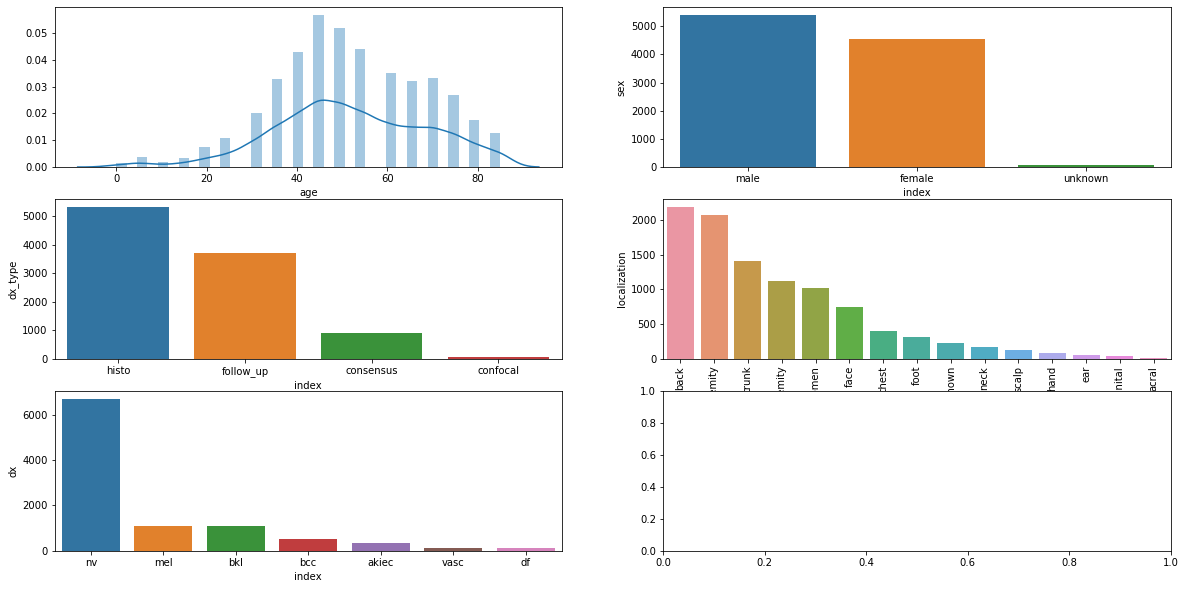

In [5]:
# get distribution for each column

fig, ax = plt.subplots(3,2, figsize=(20,10))

sns.distplot(metadata['age'], ax=ax[0,0])
sns.barplot(data=metadata['dx_type'].value_counts().reset_index(), x='index', y='dx_type', ax=ax[1,0])
sns.barplot(data=metadata['dx'].value_counts().reset_index(), x='index', y='dx', ax=ax[2,0])
sns.barplot(data=metadata['sex'].value_counts().reset_index(), x='index', y='sex', ax=ax[0,1])
sns.barplot(data=metadata['localization'].value_counts().reset_index(), x='index', y='localization', ax=ax[1,1])
ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(), rotation = 90);

### 3.2 Picture Overview

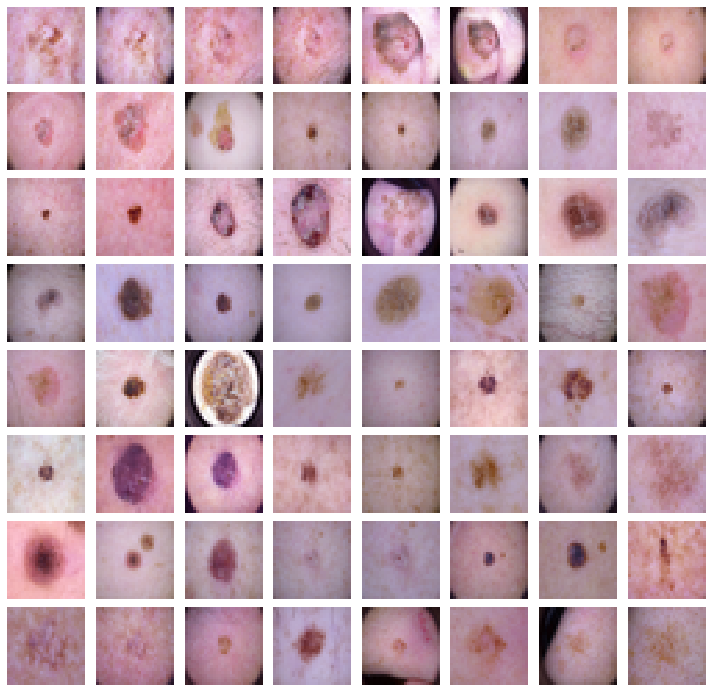

In [6]:
# Plotting 8x8 Grid of pictures

picture = data.drop(axis=1, columns='label')

fig, (ax) = plt.subplots(8, 8, figsize = (10, 10))
k = 0 
for i in range(8):
    for j in range(8):
        ax[i,j].imshow(picture.loc[k].values.reshape(28,28,3))
        ax[i,j].axis('off')
        k += 1  
    plt.tight_layout()

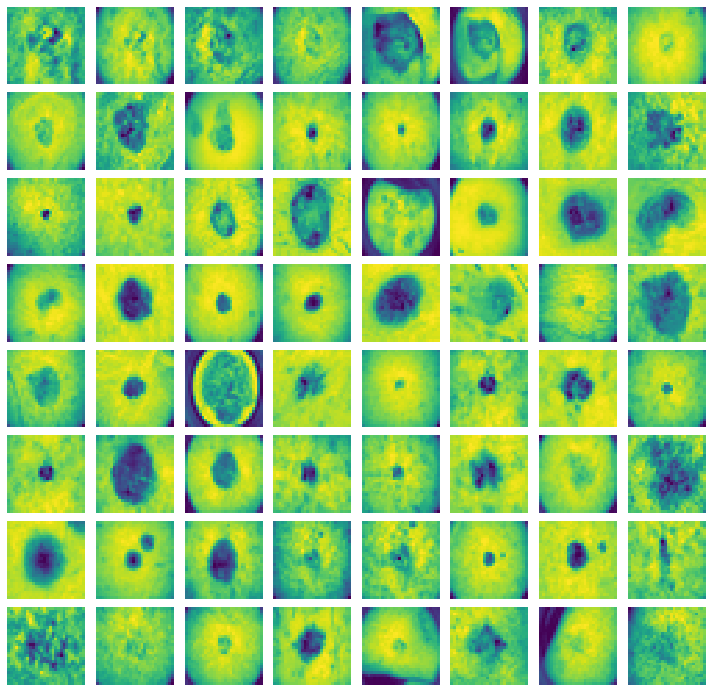

In [7]:
# Plotting 8x8 Grid of negative pictures

picture2 = data2.drop(axis=1, columns='label')

fig, (ax) = plt.subplots(8, 8, figsize = (10, 10))
k = 0 
for i in range(8):
    for j in range(8):
        ax[i,j].imshow(picture2.loc[k].values.reshape(28,28))
        ax[i,j].axis('off')
        k += 1  
    plt.tight_layout()

# 3. Data Preprocessing

In [8]:
# splitting data into X = features & y = labels

X = data.drop(axis=1, columns='label')
y = data['label']

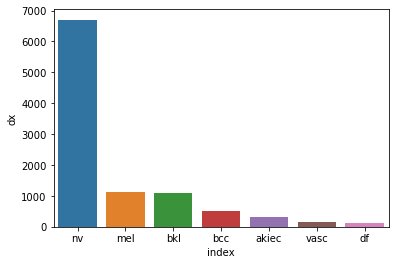

In [9]:
sns.barplot(data=metadata['dx'].value_counts().reset_index(), x='index', y='dx')

As seen in this plot the data isn't well distributed. To deal with the issue an Over-/Undersampler is used. 

In [10]:
over = {3: 1000, 5: 1000, 0: 1500, 1: 1500, 2: 2000, 6:2000}
under = {4: 3000}

oversample = RandomOverSampler(sampling_strategy=over)
undersample = RandomUnderSampler(sampling_strategy=under)

X,y  = oversample.fit_resample(X,y)

X, y = undersample.fit_resample(X, y)

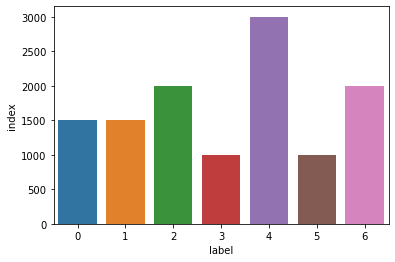

In [11]:
# new distributed data
sns.barplot(data=y.reset_index().groupby('label').count().reset_index(), x='label', y='index')

In [12]:
# Splitting the data into random training and test data of labels and features with 20% test dat'a and 80% training data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Reshaping the data to arrange the pixels like in the pictures; shape 28 pixels high x 28 pixel wide x 3 rgb values
X_train = X_train.values.reshape(X_train.shape[0], 28, 28, 3)
X_test = X_test.values.reshape(X_test.shape[0], 28, 28, 3)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [14]:
# normalisation for faster learning & convergence
X_train /= 255
X_test /= 255

In [15]:
# Encoding of labels in 7 categories
n_classes = 7
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (9600,)
Shape after one-hot encoding:  (9600, 7)


# 4. Models

Models are created using keras. Keras is a Python API, using tensorflow as backend. It's goal is to offer "fast experimentation", getting a fast result. Keras allows us easy build neural networks. It offers two ways to create models: sequential models & functional models. Sequential models are easier to construct, but may lack in some variability, which functional models resolve. In this use case we utilize different sequential models. Those models will be neural networks or more specific convolutional neural networks (CNN). CNNs are widely used for image classification and similar tasks.  

Source: \
https://keras.io/about/ \
https://en.wikipedia.org/wiki/Convolutional_neural_network

In [90]:
# Loading models
model1_load = keras.models.load_model("{}/model1".format(path))
model2_load = keras.models.load_model("{}/model2".format(path))
model3_load = keras.models.load_model("{}/model3".format(path))
model4_load = keras.models.load_model("{}/model4".format(path))
model6_load = keras.models.load_model("{}/model6".format(path))
model10_load = keras.models.load_model("{}/model10".format(path))
model11_load = keras.models.load_model("{}/model11".format(path))
final_model_load = keras.models.load_model("{}/final_model".format(path))

In [16]:
X2 = data.drop(axis=1, columns='label')
y2 = data['label']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

X_train2 = X_train2.values.reshape(X_train2.shape[0], 28, 28, 3)
X_test2 = X_test2.values.reshape(X_test2.shape[0], 28, 28, 3)
X_train2 = X_train2.astype('float32')
X_test2 = X_test2.astype('float32')

X_train2 /= 255
X_test2 /= 255

n_classes = 7
Y_train2 = np_utils.to_categorical(y_train2, n_classes)
Y_test2 = np_utils.to_categorical(y_test2, n_classes)

**If you don't want to train all models again, you can skip from here directly to the evaluation part. The whole part below, will take about 55 hours.**

**First basic model with one Convolutional, Pooling and 1 Dense Layer + Output layer. This one and the next one are the same models but the first one without Under- & Oversampler, the seconde one with Under- & Oversampler. We see that in those basic/simple models, the impact is marginal.**

### Model 1

In [17]:
# creating a model with 1 convolutional layer, 2 dense layer 

# building a linear stack of layers with the sequential model
model1 = Sequential()
# convolutional layer
model1.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,3)))
model1.add(MaxPool2D(pool_size=(1,1))) 
# flatten output of conv
model1.add(Flatten())
# hidden layer
model1.add(Dense(100, activation='relu'))
# output layer
model1.add(Dense(7, activation='softmax'))

# compiling the sequential model
model1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model for 10 epochs
history1 = model1.fit(X_train2, Y_train2, batch_size=128, epochs=20, validation_data=(X_test2, Y_test2), verbose=2)

Train on 8012 samples, validate on 2003 samples
Epoch 1/20
 - 5s - loss: 1.1151 - accuracy: 0.6549 - val_loss: 0.9539 - val_accuracy: 0.6680
Epoch 2/20
 - 5s - loss: 0.9049 - accuracy: 0.6784 - val_loss: 0.8869 - val_accuracy: 0.6710
Epoch 3/20
 - 5s - loss: 0.8494 - accuracy: 0.6907 - val_loss: 0.8616 - val_accuracy: 0.6860
Epoch 4/20
 - 6s - loss: 0.7987 - accuracy: 0.7102 - val_loss: 0.8154 - val_accuracy: 0.7124
Epoch 5/20
 - 5s - loss: 0.7560 - accuracy: 0.7260 - val_loss: 0.7891 - val_accuracy: 0.7124
Epoch 6/20
 - 5s - loss: 0.7256 - accuracy: 0.7351 - val_loss: 0.8060 - val_accuracy: 0.7019
Epoch 7/20
 - 5s - loss: 0.7280 - accuracy: 0.7280 - val_loss: 0.7712 - val_accuracy: 0.7244
Epoch 8/20
 - 5s - loss: 0.6908 - accuracy: 0.7493 - val_loss: 0.7653 - val_accuracy: 0.7199
Epoch 9/20
 - 6s - loss: 0.6575 - accuracy: 0.7609 - val_loss: 0.7555 - val_accuracy: 0.7184
Epoch 10/20
 - 5s - loss: 0.6478 - accuracy: 0.7650 - val_loss: 0.7659 - val_accuracy: 0.7204
Epoch 11/20
 - 5s - l

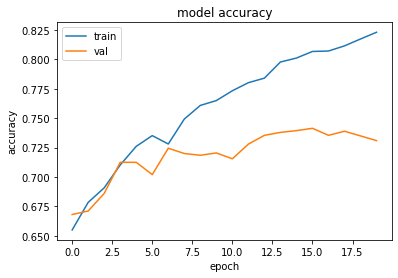

In [18]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
eval = model1.evaluate(X_test2, Y_test2)

print('test loss, test acc: ' + str(eval[0]) + ', '+ str(eval[1]))

2003/2003 [==============================] - 1s 265us/step
test loss, test acc: 0.7400116408638995, 0.7309036254882812


In [63]:
# loaded model1 from file
eval = model1_load.evaluate(X_test2, Y_test2)

print('test loss, test acc: ' + str(eval[0]) + ', '+ str(eval[1]))

2003/2003 [==============================] - 1s 270us/step
test loss, test acc: 0.7400116408638995, 0.7309036254882812


### Model 2

In [20]:
# creating a model with 1 convolutional layer, 2 dense layer 

# building a linear stack of layers with the sequential model
model2 = Sequential()
# convolutional layer
model2.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,3)))
model2.add(MaxPool2D(pool_size=(1,1))) 
# flatten output of conv
model2.add(Flatten())
# hidden layer
model2.add(Dense(100, activation='relu'))
# output layer
model2.add(Dense(7, activation='softmax'))

# compiling the sequential model
model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model for 10 epochs
history2 = model2.fit(X_train, Y_train, batch_size=128, epochs=20, validation_data=(X_test, Y_test), verbose=2)

Train on 9600 samples, validate on 2400 samples
Epoch 1/20
 - 6s - loss: 1.8070 - accuracy: 0.3121 - val_loss: 1.5988 - val_accuracy: 0.3879
Epoch 2/20
 - 6s - loss: 1.4683 - accuracy: 0.4316 - val_loss: 1.4951 - val_accuracy: 0.4196
Epoch 3/20
 - 6s - loss: 1.3288 - accuracy: 0.4821 - val_loss: 1.2942 - val_accuracy: 0.5029
Epoch 4/20
 - 6s - loss: 1.2283 - accuracy: 0.5355 - val_loss: 1.2213 - val_accuracy: 0.5433
Epoch 5/20
 - 6s - loss: 1.1336 - accuracy: 0.5715 - val_loss: 1.1450 - val_accuracy: 0.5638
Epoch 6/20
 - 6s - loss: 1.0868 - accuracy: 0.5874 - val_loss: 1.1592 - val_accuracy: 0.5654
Epoch 7/20
 - 6s - loss: 1.0344 - accuracy: 0.6066 - val_loss: 1.0924 - val_accuracy: 0.5783
Epoch 8/20
 - 6s - loss: 0.9924 - accuracy: 0.6284 - val_loss: 1.0222 - val_accuracy: 0.6242
Epoch 9/20
 - 6s - loss: 0.9376 - accuracy: 0.6528 - val_loss: 1.0228 - val_accuracy: 0.6237
Epoch 10/20
 - 6s - loss: 0.9013 - accuracy: 0.6696 - val_loss: 1.0112 - val_accuracy: 0.6021
Epoch 11/20
 - 6s - l

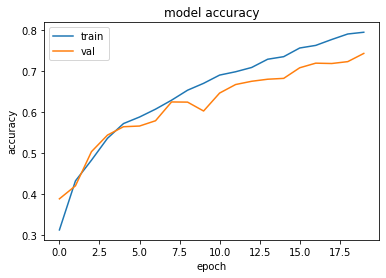

In [21]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
eval = model2.evaluate(X_test, Y_test)

print('test loss, test acc: ' + str(eval[0]) + ', '+ str(eval[1]))

2400/2400 [==============================] - 1s 300us/step
test loss, test acc: 0.7420737707614898, 0.7425000071525574


In [64]:
# loaded model2 from file
eval = model2_load.evaluate(X_test, Y_test)

print('test loss, test acc: ' + str(eval[0]) + ', '+ str(eval[1]))

2400/2400 [==============================] - 1s 313us/step
test loss, test acc: 0.6847627794742585, 0.7691666483879089


**More complex model with more Convolutional Layers and more dense layers. Now with the more complex model we see that the influence of Over-/Undersampling has a significant impact.**

### Model 3

In [23]:
# Model with Over-/Undersampling
# building a linear stack of layers with the sequential model3
model3 = Sequential()

# convolutional layer
# creating 50 layer, with kernel size 3x3, that steps with increments of 1 along the axes and 
# activates relu function
model3.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(28,28,3)))

# convolutional layer
model3.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model3.add(MaxPool2D(pool_size=(2,2)))

# The Dropout layer randomly sets input units to 0 with a frequency of rate at each step 
# during training time, which helps prevent overfitting.
model3.add(Dropout(0.25))

model3.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model3.add(MaxPool2D(pool_size=(2,2)))
model3.add(Dropout(0.25))

# flatten output of conv
model3.add(Flatten())

# hidden layer
model3.add(Dense(500, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(250, activation='relu'))
model3.add(Dropout(0.3))
# output layer
model3.add(Dense(7, activation='softmax'))

# compiling the sequential model
model3.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model2 for 10 epochs
history3 = model3.fit(X_train, Y_train, batch_size=128, epochs=50, validation_data=(X_test, Y_test))

Train on 9600 samples, validate on 2400 samples
Epoch 1/50
9600/9600 [==============================] - 47s 5ms/step - loss: 1.7050 - accuracy: 0.3124 - val_loss: 1.5306 - val_accuracy: 0.3562
Epoch 2/50
9600/9600 [==============================] - 48s 5ms/step - loss: 1.3847 - accuracy: 0.4446 - val_loss: 1.2992 - val_accuracy: 0.4717
Epoch 3/50
9600/9600 [==============================] - 45s 5ms/step - loss: 1.2420 - accuracy: 0.4968 - val_loss: 1.1729 - val_accuracy: 0.5300
Epoch 4/50
9600/9600 [==============================] - 43s 4ms/step - loss: 1.1342 - accuracy: 0.5483 - val_loss: 1.0643 - val_accuracy: 0.5725
Epoch 5/50
9600/9600 [==============================] - 44s 5ms/step - loss: 1.0520 - accuracy: 0.5764 - val_loss: 0.9646 - val_accuracy: 0.6479
Epoch 6/50
9600/9600 [==============================] - 46s 5ms/step - loss: 0.9426 - accuracy: 0.6309 - val_loss: 0.9003 - val_accuracy: 0.6696
Epoch 7/50
9600/9600 [==============================] - 44s 5ms/step - loss: 0.868

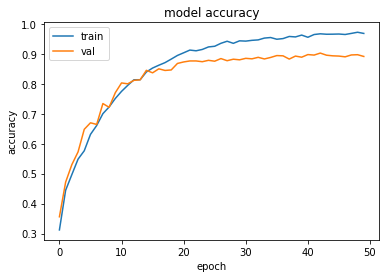

In [24]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
eval = model3.evaluate(X_test, Y_test)

print('test loss, test acc: ' + str(eval[0]) + ', '+ str(eval[1]))

2400/2400 [==============================] - 3s 1ms/step
test loss, test acc: 0.4763648535807927, 0.89083331823349


In [65]:
# loaded model3 from file
eval = model3_load.evaluate(X_test, Y_test)

print('test loss, test acc: ' + str(eval[0]) + ', '+ str(eval[1]))

2400/2400 [==============================] - 12s 5ms/step
test loss, test acc: 0.35200538878639537, 0.9208333492279053


### Model 4

In [26]:
# Model without Over-/Undersampling
# building a linear stack of layers with the sequential model3
model4 = Sequential()

# convolutional layer
# creating 50 layer, with kernel size 3x3, that steps with increments of 1 along the axes and 
# activates relu function
model4.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(28,28,3)))

# convolutional layer
model4.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model4.add(MaxPool2D(pool_size=(2,2)))

# The Dropout layer randomly sets input units to 0 with a frequency of rate at each step 
# during training time, which helps prevent overfitting.
model4.add(Dropout(0.25))

model4.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model4.add(MaxPool2D(pool_size=(2,2)))
model4.add(Dropout(0.25))

# flatten output of conv
model4.add(Flatten())

# hidden layer
model4.add(Dense(500, activation='relu'))
model4.add(Dropout(0.4))
model4.add(Dense(250, activation='relu'))
model4.add(Dropout(0.3))
# output layer
model4.add(Dense(7, activation='softmax'))

# compiling the sequential model
model4.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model2 for 10 epochs
history4 = model4.fit(X_train2, Y_train2, batch_size=128, epochs=50, validation_data=(X_test2, Y_test2))

Train on 8012 samples, validate on 2003 samples
Epoch 1/50
8012/8012 [==============================] - 35s 4ms/step - loss: 1.1180 - accuracy: 0.6555 - val_loss: 1.0097 - val_accuracy: 0.6680
Epoch 2/50
8012/8012 [==============================] - 33s 4ms/step - loss: 0.9664 - accuracy: 0.6706 - val_loss: 0.9247 - val_accuracy: 0.6675
Epoch 3/50
8012/8012 [==============================] - 34s 4ms/step - loss: 0.9020 - accuracy: 0.6791 - val_loss: 0.8740 - val_accuracy: 0.6830
Epoch 4/50
8012/8012 [==============================] - 35s 4ms/step - loss: 0.8601 - accuracy: 0.6880 - val_loss: 0.8575 - val_accuracy: 0.6880
Epoch 5/50
8012/8012 [==============================] - 37s 5ms/step - loss: 0.8381 - accuracy: 0.6896 - val_loss: 0.8267 - val_accuracy: 0.6945
Epoch 6/50
8012/8012 [==============================] - 36s 5ms/step - loss: 0.8191 - accuracy: 0.7004 - val_loss: 0.8537 - val_accuracy: 0.6905
Epoch 7/50
8012/8012 [==============================] - 35s 4ms/step - loss: 0.781

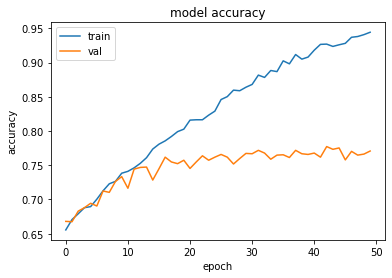

In [27]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
eval = model4.evaluate(X_test2, Y_test2)

print('test loss, test acc: ' + str(eval[0]) + ', '+ str(eval[1]))

2003/2003 [==============================] - 2s 1ms/step
test loss, test acc: 0.9152879531063322, 0.7708437442779541


In [66]:
# loaded model4 from file
eval = model4_load.evaluate(X_test2, Y_test2)

print('test loss, test acc: ' + str(eval[0]) + ', '+ str(eval[1]))

2003/2003 [==============================] - 8s 4ms/step
test loss, test acc: 0.9152879531063322, 0.7708437442779541


**More hidden layers. All Models from now on use the data with Over-/Undersampling.**

### Model 5

In [29]:
### 40 epoch, 4 hidden layer, dropout 0,2
model6 = Sequential()

# convolutional layer
# creating 50 layer, with kernel size 3x3, that steps with increments of 1 along the axes and 
# activates relu function
model6.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(28,28,3)))

# convolutional layer
model6.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model6.add(MaxPool2D(pool_size=(2,2)))

# The Dropout layer randomly sets input units to 0 with a frequency of rate at each step 
# during training time, which helps prevent overfitting.
model6.add(Dropout(0.25))

model6.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model6.add(MaxPool2D(pool_size=(2,2)))
model6.add(Dropout(0.2))

# flatten output of conv
model6.add(Flatten())

# hidden layer
model6.add(Dense(1000, activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(500, activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(250, activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(125, activation='relu'))
model6.add(Dropout(0.2))
# output layer
model6.add(Dense(7, activation='softmax'))

# compiling the sequential model6
model6.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model6 for 40 epochs
history6 = model6.fit(X_train, Y_train, batch_size=128, epochs=40, validation_data=(X_test, Y_test))

Train on 9600 samples, validate on 2400 samples
Epoch 1/40
9600/9600 [==============================] - 47s 5ms/step - loss: 1.7748 - accuracy: 0.2748 - val_loss: 1.6690 - val_accuracy: 0.3267
Epoch 2/40
9600/9600 [==============================] - 48s 5ms/step - loss: 1.5830 - accuracy: 0.3602 - val_loss: 1.5389 - val_accuracy: 0.3829
Epoch 3/40
9600/9600 [==============================] - 48s 5ms/step - loss: 1.3903 - accuracy: 0.4408 - val_loss: 1.2645 - val_accuracy: 0.4771
Epoch 4/40
9600/9600 [==============================] - 47s 5ms/step - loss: 1.2243 - accuracy: 0.5115 - val_loss: 1.1566 - val_accuracy: 0.5342
Epoch 5/40
9600/9600 [==============================] - 48s 5ms/step - loss: 1.1309 - accuracy: 0.5381 - val_loss: 1.0369 - val_accuracy: 0.5913
Epoch 6/40
9600/9600 [==============================] - 49s 5ms/step - loss: 1.0036 - accuracy: 0.6023 - val_loss: 0.9608 - val_accuracy: 0.6333
Epoch 7/40
9600/9600 [==============================] - 50s 5ms/step - loss: 0.852

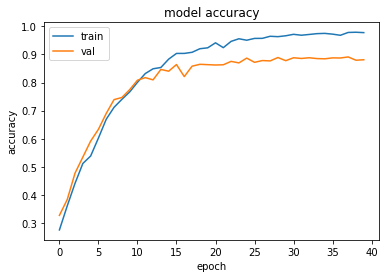

In [30]:
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
eval = model6.evaluate(X_test, Y_test)

print('test loss, test acc: ' + str(eval[0]) + ', '+ str(eval[1]))

2400/2400 [==============================] - 3s 1ms/step
test loss, test acc: 0.6159415072202683, 0.8812500238418579


In [67]:
# loaded model6 from file
eval = model6_load.evaluate(X_test, Y_test)

print('test loss, test acc: ' + str(eval[0]) + ', '+ str(eval[1]))

2400/2400 [==============================] - 12s 5ms/step
test loss, test acc: 0.4819704537714521, 0.9070833325386047


**Added Batchnormalization, added hidden layers, changed dropout**

### Model 6

In [34]:
### 50 epoch, 2 conv. layer 5 hidden layer, dropout 0,2, kicked first dropout layer
model10 = Sequential()

# convolutional layer
# creating 50 layer, with kernel size 3x3, that steps with increments of 1 along the axes and 
# activates relu function
model10.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(28,28,3)))
model10.add(BatchNormalization())

# convolutional layer
model10.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model10.add(MaxPool2D(pool_size=(2,2)))
model10.add(BatchNormalization())
# The Dropout layer randomly sets input units to 0 with a frequency of rate at each step 
# during training time, which helps prevent overfitting.

model10.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model10.add(MaxPool2D(pool_size=(2,2)))
model10.add(Dropout(0.2))

# flatten output of conv
model10.add(Flatten())

# hidden layer
model10.add(Dense(1024, activation='relu'))
model10.add(Dropout(0.2))
model10.add(Dense(512, activation='relu'))
model10.add(BatchNormalization())
model10.add(Dropout(0.2))
model10.add(Dense(256, activation='relu'))
model10.add(BatchNormalization())
model10.add(Dropout(0.2))
model10.add(Dense(128, activation='relu'))
model10.add(BatchNormalization())
model10.add(Dropout(0.2))
model10.add(Dense(64, activation='relu'))
model10.add(BatchNormalization())
model10.add(Dropout(0.2))
# output layer
model10.add(Dense(7, activation='softmax'))

# compiling the sequential model10
model10.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model10 for 20 epochs
history10 = model10.fit(X_train, Y_train, batch_size=128, epochs=50, validation_data=(X_test, Y_test))

Train on 9600 samples, validate on 2400 samples
Epoch 1/50
9600/9600 [==============================] - 72s 8ms/step - loss: 1.8950 - accuracy: 0.3252 - val_loss: 3.0637 - val_accuracy: 0.1154
Epoch 2/50
9600/9600 [==============================] - 73s 8ms/step - loss: 1.3671 - accuracy: 0.4744 - val_loss: 2.9695 - val_accuracy: 0.2262
Epoch 3/50
9600/9600 [==============================] - 73s 8ms/step - loss: 1.1809 - accuracy: 0.5435 - val_loss: 2.8705 - val_accuracy: 0.1721
Epoch 4/50
9600/9600 [==============================] - 74s 8ms/step - loss: 1.1033 - accuracy: 0.5711 - val_loss: 2.2672 - val_accuracy: 0.3850
Epoch 5/50
9600/9600 [==============================] - 77s 8ms/step - loss: 0.9887 - accuracy: 0.6170 - val_loss: 2.0888 - val_accuracy: 0.3375
Epoch 6/50
9600/9600 [==============================] - 75s 8ms/step - loss: 0.8934 - accuracy: 0.6579 - val_loss: 2.0877 - val_accuracy: 0.3400
Epoch 7/50
9600/9600 [==============================] - 76s 8ms/step - loss: 0.766

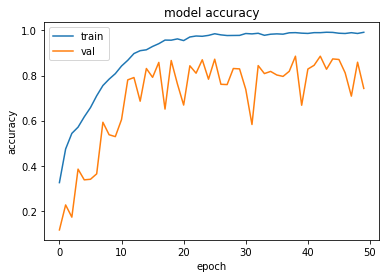

In [35]:
plt.plot(history10.history['accuracy'])
plt.plot(history10.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [89]:
eval = model10.evaluate(X_test, Y_test)

print('test loss, test acc: ' + str(eval[0]) + ', '+ str(eval[1]))

2400/2400 [==============================] - 13s 5ms/step
test loss, test acc: 1.1296027159690858, 0.7595833539962769


In [69]:
# loaded model10 from file
eval = model10_load.evaluate(X_test, Y_test)

print('test loss, test acc: ' + str(eval[0]) + ', '+ str(eval[1]))

2400/2400 [==============================] - 17s 7ms/step
test loss, test acc: 1.1296027159690858, 0.7595833539962769


**Different Approach, multiple Convolutional layers before pooling. And low amount of hidden layers.**

### Model 7

In [41]:
model11 = Sequential([
    Conv2D(16, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(28,28,3)),
    Conv2D(16, kernel_size=(3, 3), activation='relu',padding='same'),
    MaxPool2D(pool_size=(2, 2),strides=2),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax')
])

model11.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

history11 = model11.fit(X_train, Y_train, batch_size=128, epochs=50, validation_data=(X_test, Y_test))

Train on 9600 samples, validate on 2400 samples
Epoch 1/50
9600/9600 [==============================] - 9s 975us/step - loss: 1.6573 - accuracy: 0.3346 - val_loss: 1.5005 - val_accuracy: 0.4283
Epoch 2/50
9600/9600 [==============================] - 11s 1ms/step - loss: 1.3323 - accuracy: 0.4781 - val_loss: 1.2732 - val_accuracy: 0.4979
Epoch 3/50
9600/9600 [==============================] - 11s 1ms/step - loss: 1.2044 - accuracy: 0.5304 - val_loss: 1.1594 - val_accuracy: 0.5421
Epoch 4/50
9600/9600 [==============================] - 11s 1ms/step - loss: 1.0997 - accuracy: 0.5718 - val_loss: 1.1380 - val_accuracy: 0.5696
Epoch 5/50
9600/9600 [==============================] - 12s 1ms/step - loss: 1.0172 - accuracy: 0.6006 - val_loss: 1.0584 - val_accuracy: 0.6029
Epoch 6/50
9600/9600 [==============================] - 12s 1ms/step - loss: 0.9728 - accuracy: 0.6152 - val_loss: 0.9586 - val_accuracy: 0.6308
Epoch 7/50
9600/9600 [==============================] - 11s 1ms/step - loss: 0.89

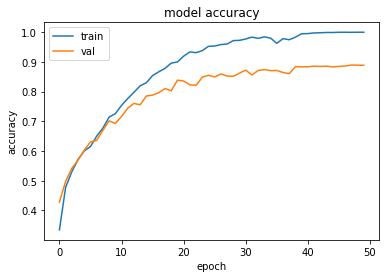

In [42]:
plt.plot(history11.history['accuracy'])
plt.plot(history11.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [43]:
eval = model11.evaluate(X_test, Y_test)

print('test loss, test acc: ' + str(eval[0]) + ', '+ str(eval[1]))

2400/2400 [==============================] - 1s 296us/step
test loss, test acc: 0.798754278557996, 0.8887500166893005


In [70]:
# loaded model11 from file
eval = model11_load.evaluate(X_test, Y_test)

print('test loss, test acc: ' + str(eval[0]) + ', '+ str(eval[1]))

2400/2400 [==============================] - 2s 848us/step
test loss, test acc: 0.5963941250182688, 0.9079166650772095


**Hyperparameter Optimization with hyperas.**

In [44]:
def data():
    data_pic = pd.read_csv(r'C:\Users\muellerm\Desktop\EXAMPLESTEXT/hmnist_28_28_RGB.csv')
    X = data_pic.drop(axis=1, columns='label')
    y = data_pic['label']
    
    over = {3: 1000, 5: 1000, 0: 1500, 1: 1500, 2: 2000, 6:2000}
    under = {4: 3000}

    oversample = RandomOverSampler(sampling_strategy=over)
    undersample = RandomUnderSampler(sampling_strategy=under)

    X,y  = oversample.fit_resample(X,y)

    X, y = undersample.fit_resample(X, y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X_train = X_train.values.reshape(X_train.shape[0], 28, 28, 3)
    X_test = X_test.values.reshape(X_test.shape[0], 28, 28, 3)
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')    
    
    X_train /= 255
    X_test /= 255
    
    n_classes = 7
    Y_train = np_utils.to_categorical(y_train, n_classes)
    Y_test = np_utils.to_categorical(y_test, n_classes)
    
    return X_train, Y_train, X_test, Y_test

In [52]:
def model(X_train, Y_train, X_test, Y_test):
    
    model = Sequential()
    model_choice = {{choice(['one', 'two', 'three'])}}
    if model_choice == 'one':
        model.add(Conv2D(16, kernel_size=3, activation='relu',padding='same', input_shape=(28,28,3), data_format='channels_first'))
        model.add(Conv2D(16, kernel_size=3, activation='relu',padding='same'))
        model.add(MaxPool2D(pool_size=2,strides=2))
        model.add(Dropout({{uniform(0, 1)}}))
        model.add(Conv2D(32, kernel_size=3, activation='relu'))
        model.add(Conv2D(32, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=2,strides=2))
        model.add(Dropout({{uniform(0, 1)}}))
    elif model_choice == 'two':
        model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(28,28,3)))
        model.add(BatchNormalization())

        # convolutional layer
        model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(BatchNormalization())
        # The Dropout layer randomly sets input units to 0 with a frequency of rate at each step 
        # during training time, which helps prevent overfitting.

        model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Dropout({{uniform(0, 1)}}))
    elif model_choice == "three":
        model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(28,28,3)))

        # convolutional layer
        model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))

        # The Dropout layer randomly sets input units to 0 with a frequency of rate at each step 
        # during training time, which helps prevent overfitting.
        model.add(Dropout({{uniform(0, 1)}}))

        model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Dropout({{uniform(0, 1)}}))
        
    
    model.add(Flatten())
    model.add(Dense({{choice([256, 512,1024])}}, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout({{uniform(0, 1)}}))
    choiceval = {{choice(['one', 'two', 'three', 'four'])}}
    if choiceval == 'two':
        model.add(Dense({{choice([256, 512,1024])}}, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout({{uniform(0, 1)}}))
    elif choiceval == 'three':
        model.add(Dense({{choice([256, 512,1024])}}, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout({{uniform(0, 1)}}))
        model.add(Dense({{choice([128, 256, 512])}}, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout({{uniform(0, 1)}}))
    elif choiceval == 'four':
        model.add(Dense({{choice([256, 512,1024])}}, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout({{uniform(0, 1)}}))
        model.add(Dense({{choice([128, 256, 512])}}, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout({{uniform(0, 1)}}))
        model.add(Dense({{choice([32, 64, 128])}}, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout({{uniform(0, 1)}}))
    
    model.add(Dense(7, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
                  optimizer='adam')
    model.fit(X_train, Y_train,
              batch_size=128,
              nb_epoch=45,
              verbose=2,
              validation_data=(X_test, Y_test))
    
    K.clear_session()
    
    score, acc = model.evaluate(X_test, Y_test, verbose=0)
    print('test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK}

In [53]:
X_train, Y_train, X_test, Y_test = data()
best_run, best_model = optim.minimize(model=model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=50,
                                      trials=Trials(),
                                      notebook_name='Skin_Cancer_Data_Exploration')

>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from keras.datasets import mnist
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
except:
    pass

try:
    from keras.layers.normalization import BatchNormalization
except:
    pass

try:
    from keras.utils import np_utils
except:
    pass

try:
    from keras.callbacks import ReduceLROnPlateau
except:
    pass

try:
    from sklearn.metrics import confusion_matrix, classification_report
except:
    pass

try:
    from imblearn.over_sampling import RandomOverSampler
except:
    pass

try:
    from imblearn.under_sampling import RandomUnderSampler
except:
    pass

try:
    from hyperas import optim
except:
 

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 44s - loss: 3.7285 - accuracy: 0.2102 - val_loss: 3.2582 - val_accuracy: 0.1746                                     

Epoch 2/45                                                                                                             
 - 48s - loss: 2.6282 - accuracy: 0.2616 - val_loss: 4.7798 - val_accuracy: 0.1737                                     

Epoch 3/45                                                                                                             
 - 51s - loss: 1.9073 - accuracy: 0.3355 - val_loss: 4.4304 - val_accuracy: 0.1742                                     

Epoch 4/45                                                                                                             
 - 49s - loss: 1.6433 - accuracy: 0.3

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 9s - loss: 4.3203 - accuracy: 0.1541 - val_loss: 1.8957 - val_accuracy: 0.2367                                      

Epoch 2/45                                                                                                             
 - 8s - loss: 3.3843 - accuracy: 0.1546 - val_loss: 1.9165 - val_accuracy: 0.2367                                      

Epoch 3/45                                                                                                             
 - 8s - loss: 2.6647 - accuracy: 0.1683 - val_loss: 1.9046 - val_accuracy: 0.2367                                      

Epoch 4/45                                                                                                             
 - 8s - loss: 2.2677 - accuracy: 0.17

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 85s - loss: 8.8944 - accuracy: 0.1674 - val_loss: 2.2219 - val_accuracy: 0.1371                                     

Epoch 2/45                                                                                                             
 - 84s - loss: 5.5228 - accuracy: 0.2138 - val_loss: 2.2768 - val_accuracy: 0.1258                                     

Epoch 3/45                                                                                                             
 - 83s - loss: 3.8642 - accuracy: 0.2380 - val_loss: 2.2489 - val_accuracy: 0.1283                                     

Epoch 4/45                                                                                                             
 - 81s - loss: 2.9536 - accuracy: 0.2

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 69s - loss: 1.8625 - accuracy: 0.3858 - val_loss: 2.2713 - val_accuracy: 0.1267                                     

Epoch 2/45                                                                                                             
 - 68s - loss: 1.3050 - accuracy: 0.5092 - val_loss: 2.8255 - val_accuracy: 0.1179                                     

Epoch 3/45                                                                                                             
 - 66s - loss: 1.1314 - accuracy: 0.5629 - val_loss: 2.3350 - val_accuracy: 0.1725                                     

Epoch 4/45                                                                                                             
 - 68s - loss: 1.0240 - accuracy: 0.5

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 8s - loss: 2.5806 - accuracy: 0.1605 - val_loss: 1.8897 - val_accuracy: 0.2367                                      

Epoch 2/45                                                                                                             
 - 7s - loss: 2.2032 - accuracy: 0.1994 - val_loss: 1.8879 - val_accuracy: 0.1713                                      

Epoch 3/45                                                                                                             
 - 6s - loss: 2.0168 - accuracy: 0.2251 - val_loss: 1.8954 - val_accuracy: 0.1713                                      

Epoch 4/45                                                                                                             
 - 7s - loss: 1.9136 - accuracy: 0.23

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 70s - loss: 8.1211 - accuracy: 0.1744 - val_loss: 2.8824 - val_accuracy: 0.1279                                     

Epoch 2/45                                                                                                             
 - 67s - loss: 6.2488 - accuracy: 0.1710 - val_loss: 2.4880 - val_accuracy: 0.1583                                     

Epoch 3/45                                                                                                             
 - 67s - loss: 4.9175 - accuracy: 0.1842 - val_loss: 1.9203 - val_accuracy: 0.2092                                     

Epoch 4/45                                                                                                             
 - 69s - loss: 3.8010 - accuracy: 0.1

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 9s - loss: 2.9500 - accuracy: 0.1641 - val_loss: 1.9198 - val_accuracy: 0.2367                                      

Epoch 2/45                                                                                                             
 - 8s - loss: 2.4127 - accuracy: 0.1907 - val_loss: 2.0836 - val_accuracy: 0.2367                                      

Epoch 3/45                                                                                                             
 - 8s - loss: 2.1714 - accuracy: 0.1946 - val_loss: 2.3637 - val_accuracy: 0.2367                                      

Epoch 4/45                                                                                                             
 - 8s - loss: 2.0100 - accuracy: 0.22

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 83s - loss: 2.4848 - accuracy: 0.1775 - val_loss: 1.9064 - val_accuracy: 0.2537                                     

Epoch 2/45                                                                                                             
 - 82s - loss: 2.0371 - accuracy: 0.2691 - val_loss: 1.8454 - val_accuracy: 0.3121                                     

Epoch 3/45                                                                                                             
 - 82s - loss: 1.7360 - accuracy: 0.3311 - val_loss: 1.8028 - val_accuracy: 0.3304                                     

Epoch 4/45                                                                                                             
 - 82s - loss: 1.5792 - accuracy: 0.3

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 7s - loss: 7.5612 - accuracy: 0.1452 - val_loss: 1.9178 - val_accuracy: 0.1713                                      

Epoch 2/45                                                                                                             
 - 6s - loss: 5.8089 - accuracy: 0.1493 - val_loss: 1.9002 - val_accuracy: 0.2367                                      

Epoch 3/45                                                                                                             
 - 6s - loss: 4.3453 - accuracy: 0.1538 - val_loss: 1.8950 - val_accuracy: 0.2367                                      

Epoch 4/45                                                                                                             
 - 7s - loss: 3.3572 - accuracy: 0.15

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 88s - loss: 1.5784 - accuracy: 0.4786 - val_loss: 2.0529 - val_accuracy: 0.2442                                     

Epoch 2/45                                                                                                             
 - 85s - loss: 1.0914 - accuracy: 0.5948 - val_loss: 1.8641 - val_accuracy: 0.2788                                     

Epoch 3/45                                                                                                             
 - 87s - loss: 0.9187 - accuracy: 0.6530 - val_loss: 2.2970 - val_accuracy: 0.2571                                     

Epoch 4/45                                                                                                             
 - 85s - loss: 0.8212 - accuracy: 0.6

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 95s - loss: 3.3566 - accuracy: 0.1714 - val_loss: 2.1856 - val_accuracy: 0.1267                                     

Epoch 2/45                                                                                                             
 - 93s - loss: 2.4479 - accuracy: 0.2294 - val_loss: 2.4650 - val_accuracy: 0.1267                                     

Epoch 3/45                                                                                                             
 - 88s - loss: 2.0593 - accuracy: 0.2743 - val_loss: 2.4454 - val_accuracy: 0.1379                                     

Epoch 4/45                                                                                                             
 - 88s - loss: 1.8648 - accuracy: 0.3

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 87s - loss: 1.7900 - accuracy: 0.4018 - val_loss: 2.0265 - val_accuracy: 0.2254                                     

Epoch 2/45                                                                                                             
 - 86s - loss: 1.2734 - accuracy: 0.5202 - val_loss: 2.1780 - val_accuracy: 0.1308                                     

Epoch 3/45                                                                                                             
 - 86s - loss: 1.1470 - accuracy: 0.5606 - val_loss: 2.0950 - val_accuracy: 0.2333                                     

Epoch 4/45                                                                                                             
 - 87s - loss: 1.0671 - accuracy: 0.5

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 77s - loss: 2.5519 - accuracy: 0.2107 - val_loss: 2.3089 - val_accuracy: 0.1267                                     

Epoch 2/45                                                                                                             
 - 76s - loss: 1.9827 - accuracy: 0.2984 - val_loss: 2.4944 - val_accuracy: 0.1267                                     

Epoch 3/45                                                                                                             
 - 75s - loss: 1.7601 - accuracy: 0.3324 - val_loss: 2.6454 - val_accuracy: 0.1267                                     

Epoch 4/45                                                                                                             
 - 77s - loss: 1.6362 - accuracy: 0.3

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 8s - loss: 3.6369 - accuracy: 0.1607 - val_loss: 1.9218 - val_accuracy: 0.2367                                      

Epoch 2/45                                                                                                             
 - 7s - loss: 2.9541 - accuracy: 0.1746 - val_loss: 1.9437 - val_accuracy: 0.2367                                      

Epoch 3/45                                                                                                             
 - 7s - loss: 2.4568 - accuracy: 0.1801 - val_loss: 1.9873 - val_accuracy: 0.2367                                      

Epoch 4/45                                                                                                             
 - 7s - loss: 2.2215 - accuracy: 0.18

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 80s - loss: 6.5782 - accuracy: 0.2044 - val_loss: 1.9498 - val_accuracy: 0.2367                                     

Epoch 2/45                                                                                                             
 - 78s - loss: 5.2107 - accuracy: 0.2065 - val_loss: 1.9204 - val_accuracy: 0.2367                                     

Epoch 3/45                                                                                                             
 - 79s - loss: 4.2268 - accuracy: 0.2083 - val_loss: 1.9031 - val_accuracy: 0.2367                                     

Epoch 4/45                                                                                                             
 - 77s - loss: 3.4723 - accuracy: 0.2

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 72s - loss: 1.7218 - accuracy: 0.4013 - val_loss: 2.2214 - val_accuracy: 0.2133                                     

Epoch 2/45                                                                                                             
 - 72s - loss: 1.2970 - accuracy: 0.5131 - val_loss: 2.1916 - val_accuracy: 0.1754                                     

Epoch 3/45                                                                                                             
 - 73s - loss: 1.1594 - accuracy: 0.5561 - val_loss: 2.2412 - val_accuracy: 0.3021                                     

Epoch 4/45                                                                                                             
 - 73s - loss: 1.0418 - accuracy: 0.6

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 80s - loss: 2.1035 - accuracy: 0.3554 - val_loss: 2.9262 - val_accuracy: 0.1733                                     

Epoch 2/45                                                                                                             
 - 80s - loss: 1.5034 - accuracy: 0.4570 - val_loss: 2.8387 - val_accuracy: 0.2188                                     

Epoch 3/45                                                                                                             
 - 78s - loss: 1.2790 - accuracy: 0.5111 - val_loss: 2.1254 - val_accuracy: 0.1733                                     

Epoch 4/45                                                                                                             
 - 79s - loss: 1.1737 - accuracy: 0.5

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 8s - loss: 2.7589 - accuracy: 0.1615 - val_loss: 1.8912 - val_accuracy: 0.2367                                      

Epoch 2/45                                                                                                             
 - 7s - loss: 2.4298 - accuracy: 0.1832 - val_loss: 1.8873 - val_accuracy: 0.2367                                      

Epoch 3/45                                                                                                             
 - 7s - loss: 2.2847 - accuracy: 0.1986 - val_loss: 1.8859 - val_accuracy: 0.2367                                      

Epoch 4/45                                                                                                             
 - 7s - loss: 2.1628 - accuracy: 0.21

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 11s - loss: 2.3655 - accuracy: 0.1826 - val_loss: 1.9207 - val_accuracy: 0.1642                                     

Epoch 2/45                                                                                                             
 - 10s - loss: 1.9940 - accuracy: 0.2386 - val_loss: 1.8275 - val_accuracy: 0.2438                                     

Epoch 3/45                                                                                                             
 - 10s - loss: 1.8391 - accuracy: 0.2717 - val_loss: 1.7784 - val_accuracy: 0.2871                                     

Epoch 4/45                                                                                                             
 - 10s - loss: 1.7250 - accuracy: 0.3

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 114s - loss: 2.0733 - accuracy: 0.3578 - val_loss: 2.2023 - val_accuracy: 0.1829                                    

Epoch 2/45                                                                                                             
 - 115s - loss: 1.4588 - accuracy: 0.4761 - val_loss: 2.8812 - val_accuracy: 0.0954                                    

Epoch 3/45                                                                                                             
 - 109s - loss: 1.2286 - accuracy: 0.5404 - val_loss: 2.9022 - val_accuracy: 0.2667                                    

Epoch 4/45                                                                                                             
 - 111s - loss: 1.0771 - accuracy: 0.

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 108s - loss: 2.8115 - accuracy: 0.1951 - val_loss: 2.1177 - val_accuracy: 0.1283                                    

Epoch 2/45                                                                                                             
 - 108s - loss: 2.0601 - accuracy: 0.2804 - val_loss: 2.0514 - val_accuracy: 0.1733                                    

Epoch 3/45                                                                                                             
 - 107s - loss: 1.7796 - accuracy: 0.3148 - val_loss: 2.0109 - val_accuracy: 0.1879                                    

Epoch 4/45                                                                                                             
 - 109s - loss: 1.7058 - accuracy: 0.

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 105s - loss: 1.8269 - accuracy: 0.4105 - val_loss: 2.1138 - val_accuracy: 0.1800                                    

Epoch 2/45                                                                                                             
 - 100s - loss: 1.2170 - accuracy: 0.5346 - val_loss: 2.1131 - val_accuracy: 0.1775                                    

Epoch 3/45                                                                                                             
 - 102s - loss: 1.0715 - accuracy: 0.5870 - val_loss: 2.0841 - val_accuracy: 0.1733                                    

Epoch 4/45                                                                                                             
 - 101s - loss: 0.9581 - accuracy: 0.

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 114s - loss: 1.3601 - accuracy: 0.5215 - val_loss: 2.0766 - val_accuracy: 0.0887                                    

Epoch 2/45                                                                                                             
 - 115s - loss: 0.9028 - accuracy: 0.6644 - val_loss: 2.0574 - val_accuracy: 0.2204                                    

Epoch 3/45                                                                                                             
 - 118s - loss: 0.7503 - accuracy: 0.7220 - val_loss: 2.1803 - val_accuracy: 0.2458                                    

Epoch 4/45                                                                                                             
 - 113s - loss: 0.6275 - accuracy: 0.

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 80s - loss: 1.5045 - accuracy: 0.4403 - val_loss: 1.8144 - val_accuracy: 0.2367                                     

Epoch 2/45                                                                                                             
 - 78s - loss: 1.1386 - accuracy: 0.5605 - val_loss: 1.7861 - val_accuracy: 0.2367                                     

Epoch 3/45                                                                                                             
 - 78s - loss: 0.9867 - accuracy: 0.6162 - val_loss: 1.7103 - val_accuracy: 0.2421                                     

Epoch 4/45                                                                                                             
 - 79s - loss: 0.8519 - accuracy: 0.6

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 78s - loss: 1.6613 - accuracy: 0.3904 - val_loss: 1.8175 - val_accuracy: 0.2367                                     

Epoch 2/45                                                                                                             
 - 77s - loss: 1.1801 - accuracy: 0.5370 - val_loss: 1.7667 - val_accuracy: 0.2367                                     

Epoch 3/45                                                                                                             
 - 74s - loss: 1.0363 - accuracy: 0.5954 - val_loss: 1.6753 - val_accuracy: 0.2383                                     

Epoch 4/45                                                                                                             
 - 74s - loss: 0.9366 - accuracy: 0.6

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 93s - loss: 1.9523 - accuracy: 0.3299 - val_loss: 1.8101 - val_accuracy: 0.3313                                     

Epoch 2/45                                                                                                             
 - 91s - loss: 1.3088 - accuracy: 0.4892 - val_loss: 1.7722 - val_accuracy: 0.3017                                     

Epoch 3/45                                                                                                             
 - 89s - loss: 1.1723 - accuracy: 0.5401 - val_loss: 1.6895 - val_accuracy: 0.3000                                     

Epoch 4/45                                                                                                             
 - 89s - loss: 1.0789 - accuracy: 0.5

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 81s - loss: 1.9962 - accuracy: 0.3168 - val_loss: 1.8397 - val_accuracy: 0.2367                                     

Epoch 2/45                                                                                                             
 - 84s - loss: 1.3217 - accuracy: 0.4785 - val_loss: 1.8016 - val_accuracy: 0.2367                                     

Epoch 3/45                                                                                                             
 - 83s - loss: 1.2025 - accuracy: 0.5336 - val_loss: 1.7071 - val_accuracy: 0.2371                                     

Epoch 4/45                                                                                                             
 - 80s - loss: 1.1490 - accuracy: 0.5

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 80s - loss: 1.8652 - accuracy: 0.3454 - val_loss: 1.8491 - val_accuracy: 0.2367                                     

Epoch 2/45                                                                                                             
 - 83s - loss: 1.2565 - accuracy: 0.5090 - val_loss: 1.8198 - val_accuracy: 0.2379                                     

Epoch 3/45                                                                                                             
 - 79s - loss: 1.1139 - accuracy: 0.5705 - val_loss: 1.7643 - val_accuracy: 0.2367                                     

Epoch 4/45                                                                                                             
 - 78s - loss: 1.0367 - accuracy: 0.5

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 86s - loss: 2.2844 - accuracy: 0.2205 - val_loss: 2.0176 - val_accuracy: 0.2367                                     

Epoch 2/45                                                                                                             
 - 92s - loss: 1.8339 - accuracy: 0.2843 - val_loss: 2.0319 - val_accuracy: 0.2367                                     

Epoch 3/45                                                                                                             
 - 88s - loss: 1.8100 - accuracy: 0.2887 - val_loss: 2.0665 - val_accuracy: 0.2367                                     

Epoch 4/45                                                                                                             
 - 88s - loss: 1.7818 - accuracy: 0.2

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 86s - loss: 2.0689 - accuracy: 0.2989 - val_loss: 1.8365 - val_accuracy: 0.2367                                     

Epoch 2/45                                                                                                             
 - 84s - loss: 1.3488 - accuracy: 0.4749 - val_loss: 1.7850 - val_accuracy: 0.2371                                     

Epoch 3/45                                                                                                             
 - 86s - loss: 1.2682 - accuracy: 0.5059 - val_loss: 1.6956 - val_accuracy: 0.2417                                     

Epoch 4/45                                                                                                             
 - 85s - loss: 1.1485 - accuracy: 0.5

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 89s - loss: 2.2325 - accuracy: 0.2227 - val_loss: 1.8703 - val_accuracy: 0.2508                                     

Epoch 2/45                                                                                                             
 - 90s - loss: 1.7032 - accuracy: 0.3529 - val_loss: 2.5082 - val_accuracy: 0.2150                                     

Epoch 3/45                                                                                                             
 - 87s - loss: 1.5147 - accuracy: 0.4135 - val_loss: 2.5312 - val_accuracy: 0.2887                                     

Epoch 4/45                                                                                                             
 - 88s - loss: 1.3916 - accuracy: 0.4

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 81s - loss: 1.4946 - accuracy: 0.4426 - val_loss: 1.7427 - val_accuracy: 0.2367                                     

Epoch 2/45                                                                                                             
 - 82s - loss: 1.1036 - accuracy: 0.5794 - val_loss: 1.6497 - val_accuracy: 0.2396                                     

Epoch 3/45                                                                                                             
 - 83s - loss: 0.9617 - accuracy: 0.6267 - val_loss: 1.5335 - val_accuracy: 0.3192                                     

Epoch 4/45                                                                                                             
 - 82s - loss: 0.8862 - accuracy: 0.6

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 87s - loss: 2.4896 - accuracy: 0.1863 - val_loss: 1.9518 - val_accuracy: 0.2367                                     

Epoch 2/45                                                                                                             
 - 86s - loss: 1.9694 - accuracy: 0.2920 - val_loss: 1.8163 - val_accuracy: 0.2625                                     

Epoch 3/45                                                                                                             
 - 88s - loss: 1.7036 - accuracy: 0.3481 - val_loss: 1.8017 - val_accuracy: 0.3050                                     

Epoch 4/45                                                                                                             
 - 89s - loss: 1.5649 - accuracy: 0.3

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 92s - loss: 1.7227 - accuracy: 0.4507 - val_loss: 1.9993 - val_accuracy: 0.1417                                     

Epoch 2/45                                                                                                             
 - 94s - loss: 1.1530 - accuracy: 0.5694 - val_loss: 2.1760 - val_accuracy: 0.1808                                     

Epoch 3/45                                                                                                             
 - 91s - loss: 0.9935 - accuracy: 0.6190 - val_loss: 1.9955 - val_accuracy: 0.1733                                     

Epoch 4/45                                                                                                             
 - 92s - loss: 0.8933 - accuracy: 0.6

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 93s - loss: 2.6018 - accuracy: 0.2498 - val_loss: 2.2576 - val_accuracy: 0.1925                                     

Epoch 2/45                                                                                                             
 - 92s - loss: 1.7402 - accuracy: 0.3389 - val_loss: 1.9071 - val_accuracy: 0.2567                                     

Epoch 3/45                                                                                                             
 - 91s - loss: 1.4993 - accuracy: 0.4247 - val_loss: 2.0353 - val_accuracy: 0.2225                                     

Epoch 4/45                                                                                                             
 - 92s - loss: 1.3353 - accuracy: 0.4

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 89s - loss: 2.9682 - accuracy: 0.2019 - val_loss: 1.9287 - val_accuracy: 0.2154                                     

Epoch 2/45                                                                                                             
 - 90s - loss: 2.1910 - accuracy: 0.2964 - val_loss: 5.6093 - val_accuracy: 0.2029                                     

Epoch 3/45                                                                                                             
 - 88s - loss: 1.7605 - accuracy: 0.3485 - val_loss: 5.3199 - val_accuracy: 0.1854                                     

Epoch 4/45                                                                                                             
 - 87s - loss: 1.5725 - accuracy: 0.3

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 123s - loss: 1.7469 - accuracy: 0.4559 - val_loss: 2.0869 - val_accuracy: 0.2375                                    

Epoch 2/45                                                                                                             
 - 125s - loss: 1.1595 - accuracy: 0.5752 - val_loss: 2.2523 - val_accuracy: 0.1733                                    

Epoch 3/45                                                                                                             
 - 120s - loss: 0.9743 - accuracy: 0.6293 - val_loss: 2.2295 - val_accuracy: 0.1733                                    

Epoch 4/45                                                                                                             
 - 131s - loss: 0.8856 - accuracy: 0.

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 10s - loss: 11.7795 - accuracy: 0.1558 - val_loss: 2.1151 - val_accuracy: 0.1267                                    

Epoch 2/45                                                                                                             
 - 9s - loss: 6.1368 - accuracy: 0.1716 - val_loss: 1.9804 - val_accuracy: 0.1629                                      

Epoch 3/45                                                                                                             
 - 10s - loss: 3.5504 - accuracy: 0.1859 - val_loss: 1.8965 - val_accuracy: 0.2212                                     

Epoch 4/45                                                                                                             
 - 9s - loss: 2.3974 - accuracy: 0.20

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 116s - loss: 2.3475 - accuracy: 0.2539 - val_loss: 1.6755 - val_accuracy: 0.3512                                    

Epoch 2/45                                                                                                             
 - 115s - loss: 1.6571 - accuracy: 0.3850 - val_loss: 1.5913 - val_accuracy: 0.3562                                    

Epoch 3/45                                                                                                             
 - 109s - loss: 1.3950 - accuracy: 0.4684 - val_loss: 1.5531 - val_accuracy: 0.3783                                    

Epoch 4/45                                                                                                             
 - 115s - loss: 1.2486 - accuracy: 0.

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 105s - loss: 1.4162 - accuracy: 0.5210 - val_loss: 2.2566 - val_accuracy: 0.2367                                    

Epoch 2/45                                                                                                             
 - 107s - loss: 0.9289 - accuracy: 0.6606 - val_loss: 2.7975 - val_accuracy: 0.3158                                    

Epoch 3/45                                                                                                             
 - 104s - loss: 0.7277 - accuracy: 0.7361 - val_loss: 3.5441 - val_accuracy: 0.2367                                    

Epoch 4/45                                                                                                             
 - 102s - loss: 0.5870 - accuracy: 0.

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 10s - loss: 2.4323 - accuracy: 0.1858 - val_loss: 1.8993 - val_accuracy: 0.2375                                     

Epoch 2/45                                                                                                             
 - 9s - loss: 2.0477 - accuracy: 0.2362 - val_loss: 1.7959 - val_accuracy: 0.2171                                      

Epoch 3/45                                                                                                             
 - 10s - loss: 1.8614 - accuracy: 0.2795 - val_loss: 1.8374 - val_accuracy: 0.2233                                     

Epoch 4/45                                                                                                             
 - 10s - loss: 1.7328 - accuracy: 0.3

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 91s - loss: 1.3001 - accuracy: 0.5298 - val_loss: 2.1004 - val_accuracy: 0.2371                                     

Epoch 2/45                                                                                                             
 - 90s - loss: 0.9124 - accuracy: 0.6555 - val_loss: 2.0706 - val_accuracy: 0.2371                                     

Epoch 3/45                                                                                                             
 - 88s - loss: 0.7665 - accuracy: 0.7170 - val_loss: 2.5399 - val_accuracy: 0.2479                                     

Epoch 4/45                                                                                                             
 - 89s - loss: 0.6413 - accuracy: 0.7

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 85s - loss: 3.3640 - accuracy: 0.1725 - val_loss: 2.9933 - val_accuracy: 0.1329                                     

Epoch 2/45                                                                                                             
 - 82s - loss: 2.4295 - accuracy: 0.2511 - val_loss: 2.6285 - val_accuracy: 0.1863                                     

Epoch 3/45                                                                                                             
 - 82s - loss: 1.7886 - accuracy: 0.3342 - val_loss: 2.0515 - val_accuracy: 0.2996                                     

Epoch 4/45                                                                                                             
 - 82s - loss: 1.6336 - accuracy: 0.3

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 106s - loss: 2.3810 - accuracy: 0.3702 - val_loss: 2.0484 - val_accuracy: 0.2208                                    

Epoch 2/45                                                                                                             
 - 108s - loss: 1.5112 - accuracy: 0.4744 - val_loss: 2.0943 - val_accuracy: 0.1733                                    

Epoch 3/45                                                                                                             
 - 107s - loss: 1.2500 - accuracy: 0.5257 - val_loss: 2.0709 - val_accuracy: 0.1733                                    

Epoch 4/45                                                                                                             
 - 128s - loss: 1.1462 - accuracy: 0.

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 8s - loss: 2.6114 - accuracy: 0.1629 - val_loss: 1.9053 - val_accuracy: 0.1754                                      

Epoch 2/45                                                                                                             
 - 7s - loss: 2.2426 - accuracy: 0.1860 - val_loss: 1.9266 - val_accuracy: 0.2208                                      

Epoch 3/45                                                                                                             
 - 7s - loss: 2.0574 - accuracy: 0.2186 - val_loss: 1.9056 - val_accuracy: 0.2367                                      

Epoch 4/45                                                                                                             
 - 7s - loss: 1.8750 - accuracy: 0.25

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 118s - loss: 1.5326 - accuracy: 0.4795 - val_loss: 2.5482 - val_accuracy: 0.0925                                    

Epoch 2/45                                                                                                             
 - 115s - loss: 1.0375 - accuracy: 0.6176 - val_loss: 2.8959 - val_accuracy: 0.1904                                    

Epoch 3/45                                                                                                             
 - 113s - loss: 0.8766 - accuracy: 0.6709 - val_loss: 3.1711 - val_accuracy: 0.1733                                    

Epoch 4/45                                                                                                             
 - 114s - loss: 0.7730 - accuracy: 0.

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 102s - loss: 2.4550 - accuracy: 0.1934 - val_loss: 1.8743 - val_accuracy: 0.2500                                    

Epoch 2/45                                                                                                             
 - 99s - loss: 1.9674 - accuracy: 0.2703 - val_loss: 2.6449 - val_accuracy: 0.1725                                     

Epoch 3/45                                                                                                             
 - 103s - loss: 1.7446 - accuracy: 0.3261 - val_loss: 4.5122 - val_accuracy: 0.1758                                    

Epoch 4/45                                                                                                             
 - 103s - loss: 1.5715 - accuracy: 0.

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 11s - loss: 2.9356 - accuracy: 0.1760 - val_loss: 1.8262 - val_accuracy: 0.2788                                     

Epoch 2/45                                                                                                             
 - 10s - loss: 2.2406 - accuracy: 0.2505 - val_loss: 2.2312 - val_accuracy: 0.3187                                     

Epoch 3/45                                                                                                             
 - 9s - loss: 1.8790 - accuracy: 0.3158 - val_loss: 2.5523 - val_accuracy: 0.1850                                      

Epoch 4/45                                                                                                             
 - 9s - loss: 1.7243 - accuracy: 0.34

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 104s - loss: 1.9983 - accuracy: 0.3776 - val_loss: 2.0078 - val_accuracy: 0.1733                                    

Epoch 2/45                                                                                                             
 - 101s - loss: 1.3914 - accuracy: 0.4782 - val_loss: 1.9413 - val_accuracy: 0.1733                                    

Epoch 3/45                                                                                                             
 - 108s - loss: 1.2273 - accuracy: 0.5234 - val_loss: 1.9531 - val_accuracy: 0.1733                                    

Epoch 4/45                                                                                                             
 - 103s - loss: 1.1365 - accuracy: 0.

C:\Users\muellerm\OneDrive - Hewlett Packard Enterprise\UNI\Semester 1\Jupyter\temp_model.py:194: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 9600 samples, validate on 2400 samples                                                                        
Epoch 1/45                                                                                                             
 - 115s - loss: 2.6914 - accuracy: 0.2783 - val_loss: 2.5806 - val_accuracy: 0.1521                                    

Epoch 2/45                                                                                                             
 - 113s - loss: 1.8438 - accuracy: 0.3707 - val_loss: 3.1772 - val_accuracy: 0.1267                                    

Epoch 3/45                                                                                                             
 - 112s - loss: 1.4881 - accuracy: 0.4420 - val_loss: 3.0338 - val_accuracy: 0.1396                                    

Epoch 4/45                                                                                                             
 - 117s - loss: 1.3414 - accuracy: 0.

In [54]:
print(best_run)

{'Dense': 1, 'Dense_1': 2, 'Dense_2': 1, 'Dense_3': 0, 'Dense_4': 0, 'Dense_5': 2, 'Dense_6': 1, 'Dropout': 0.2864809526545459, 'Dropout_1': 0.8022428689259579, 'Dropout_10': 0.35716501192619887, 'Dropout_11': 0.9470427691458846, 'Dropout_2': 0.5108356937892456, 'Dropout_3': 0.44012240043070905, 'Dropout_4': 0.8888716397829779, 'Dropout_5': 0.3686428231765312, 'Dropout_6': 0.3840653655364614, 'Dropout_7': 0.4143619965361732, 'Dropout_8': 0.09225974322037533, 'Dropout_9': 0.20942239619394942, 'choiceval': 0, 'model_choice': 1}


{'Dense': 1, 'Dense_1': 2, 'Dense_2': 1, 'Dense_3': 0, 'Dense_4': 0, 'Dense_5': 2, 'Dense_6': 1, 'Dropout': 0.2864809526545459, 'Dropout_1': 0.8022428689259579, 'Dropout_10': 0.35716501192619887, 'Dropout_11': 0.9470427691458846, 'Dropout_2': 0.5108356937892456, 'Dropout_3': 0.44012240043070905, 'Dropout_4': 0.8888716397829779, 'Dropout_5': 0.3686428231765312, 'Dropout_6': 0.3840653655364614, 'Dropout_7': 0.4143619965361732, 'Dropout_8': 0.09225974322037533, 'Dropout_9': 0.20942239619394942, 'choiceval': 0, 'model_choice': 1}

**The best model calculated by hyperas is the following model. This model is also the final model and shows our end result.**

### Final Model

In [55]:
final_model = Sequential()
final_model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(28,28,3)))
final_model.add(BatchNormalization())

# convolutional layer
final_model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
final_model.add(MaxPool2D(pool_size=(2,2)))
final_model.add(BatchNormalization())
# The Dropout layer randomly sets input units to 0 with a frequency of rate at each step 
# during training time, which helps prevent overfitting.

final_model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
final_model.add(MaxPool2D(pool_size=(2,2)))
final_model.add(Dropout(0.5))

final_model.add(Flatten())
final_model.add(Dense(512, activation='relu'))
final_model.add(BatchNormalization())
final_model.add(Dropout(0.35))

final_model.add(Dense(7, activation='softmax'))
    
final_model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
                  optimizer='adam')

history_fModel = final_model.fit(X_train, Y_train,
                                    batch_size=128,
                                    nb_epoch=45,
                                    verbose=2,
                                    validation_data=(X_test, Y_test))

C:\Users\muellerm\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:30: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 9600 samples, validate on 2400 samples
Epoch 1/45
 - 112s - loss: 1.5245 - accuracy: 0.4882 - val_loss: 2.1499 - val_accuracy: 0.2367
Epoch 2/45
 - 113s - loss: 1.0537 - accuracy: 0.6053 - val_loss: 2.1321 - val_accuracy: 0.3237
Epoch 3/45
 - 110s - loss: 0.8871 - accuracy: 0.6661 - val_loss: 2.0369 - val_accuracy: 0.2387
Epoch 4/45
 - 109s - loss: 0.7815 - accuracy: 0.7100 - val_loss: 2.5832 - val_accuracy: 0.3346
Epoch 5/45
 - 111s - loss: 0.6917 - accuracy: 0.7393 - val_loss: 2.0508 - val_accuracy: 0.3467
Epoch 6/45
 - 109s - loss: 0.6291 - accuracy: 0.7644 - val_loss: 2.1335 - val_accuracy: 0.3129
Epoch 7/45
 - 119s - loss: 0.5504 - accuracy: 0.7979 - val_loss: 1.2718 - val_accuracy: 0.5946
Epoch 8/45
 - 116s - loss: 0.5041 - accuracy: 0.8114 - val_loss: 1.1867 - val_accuracy: 0.5142
Epoch 9/45
 - 109s - loss: 0.4594 - accuracy: 0.8285 - val_loss: 0.7258 - val_accuracy: 0.7296
Epoch 10/45
 - 108s - loss: 0.3984 - accuracy: 0.8489 - val_loss: 0.6382 - val_accuracy: 0.7583
E

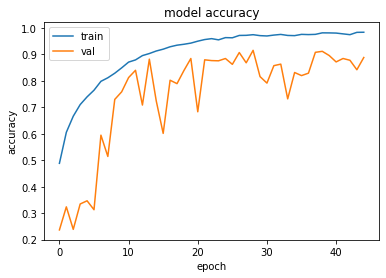

In [56]:
plt.plot(history_fModel.history['accuracy'])
plt.plot(history_fModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [57]:
eval = final_model.evaluate(X_test, Y_test)

print('test loss, test acc: ' + str(eval[0]) + ', '+ str(eval[1]))

2400/2400 [==============================] - 15s 6ms/step
test loss, test acc: 0.3909325101474921, 0.8879166841506958


In [71]:
# loaded final_model from file
eval = final_model_load.evaluate(X_test, Y_test)

print('test loss, test acc: ' + str(eval[0]) + ', '+ str(eval[1]))

2400/2400 [==============================] - 15s 6ms/step
test loss, test acc: 0.3909325101474921, 0.8879166841506958


Saving all models

In [58]:
model1.save('{}/model1'.format(path))
model2.save('{}/model2'.format(path))
model3.save('{}/model3'.format(path))
model4.save('{}/model4'.format(path))
model6.save('{}/model6'.format(path))
model10.save('{}/model10'.format(path))
model11.save('{}/model11'.format(path))
final_model.save('{}/final_model'.format(path))

# 5. Evaluation

In [82]:
# Model1 Evaluation
y_pred = model1_load.predict(X_test2, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test2, y_pred_bool))

2003/2003 [==============================] - 1s 305us/step
              precision    recall  f1-score   support

           0       0.36      0.28      0.31        69
           1       0.39      0.66      0.49        93
           2       0.60      0.22      0.32       228
           3       0.50      0.07      0.12        28
           4       0.81      0.94      0.87      1338
           5       0.56      0.48      0.51        21
           6       0.49      0.28      0.36       226

    accuracy                           0.73      2003
   macro avg       0.53      0.42      0.43      2003
weighted avg       0.71      0.73      0.70      2003



In [79]:
# Model2 Evaluation
y_pred = model2_load.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

2400/2400 [==============================] - 1s 282us/step
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       308
           1       0.69      0.81      0.75       304
           2       0.68      0.63      0.65       416
           3       0.89      0.92      0.90       208
           4       0.76      0.79      0.78       568
           5       0.94      0.97      0.95       185
           6       0.75      0.63      0.68       411

    accuracy                           0.77      2400
   macro avg       0.79      0.80      0.79      2400
weighted avg       0.77      0.77      0.77      2400



In [83]:
# Model3 Evaluation
y_pred = model3_load.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

2400/2400 [==============================] - 13s 5ms/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       308
           1       0.96      0.96      0.96       304
           2       0.93      0.84      0.88       416
           3       0.99      1.00      0.99       208
           4       0.89      0.89      0.89       568
           5       0.99      1.00      0.99       185
           6       0.84      0.88      0.86       411

    accuracy                           0.92      2400
   macro avg       0.94      0.94      0.94      2400
weighted avg       0.92      0.92      0.92      2400



In [84]:
# Model4 Evaluation
y_pred = model4_load.predict(X_test2, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test2, y_pred_bool))

2003/2003 [==============================] - 11s 5ms/step
              precision    recall  f1-score   support

           0       0.39      0.30      0.34        69
           1       0.55      0.62      0.59        93
           2       0.54      0.48      0.51       228
           3       0.71      0.18      0.29        28
           4       0.88      0.92      0.90      1338
           5       0.57      0.57      0.57        21
           6       0.52      0.49      0.50       226

    accuracy                           0.77      2003
   macro avg       0.59      0.51      0.53      2003
weighted avg       0.76      0.77      0.76      2003



In [85]:
# Model6 Evaluation
y_pred = model6_load.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

2400/2400 [==============================] - 12s 5ms/step
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       308
           1       0.94      0.96      0.95       304
           2       0.89      0.82      0.85       416
           3       1.00      1.00      1.00       208
           4       0.88      0.88      0.88       568
           5       0.97      1.00      0.99       185
           6       0.84      0.85      0.84       411

    accuracy                           0.91      2400
   macro avg       0.92      0.93      0.92      2400
weighted avg       0.91      0.91      0.91      2400



In [86]:
# Model10 Evaluation
y_pred = model10_load.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

2400/2400 [==============================] - 12s 5ms/step
              precision    recall  f1-score   support

           0       0.96      0.75      0.84       308
           1       0.99      0.65      0.78       304
           2       0.85      0.57      0.68       416
           3       0.99      0.76      0.86       208
           4       0.55      0.93      0.69       568
           5       0.89      0.99      0.94       185
           6       0.81      0.70      0.75       411

    accuracy                           0.76      2400
   macro avg       0.86      0.76      0.79      2400
weighted avg       0.82      0.76      0.76      2400



In [87]:
# Model11 Evaluation
y_pred = model11_load.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

2400/2400 [==============================] - 1s 590us/step
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       308
           1       0.95      0.96      0.96       304
           2       0.87      0.84      0.85       416
           3       0.99      1.00      1.00       208
           4       0.87      0.87      0.87       568
           5       0.99      1.00      1.00       185
           6       0.85      0.85      0.85       411

    accuracy                           0.91      2400
   macro avg       0.93      0.93      0.93      2400
weighted avg       0.91      0.91      0.91      2400



In [88]:
# Final Model Evaluation
y_pred = final_model_load.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

2400/2400 [==============================] - 11s 5ms/step
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       308
           1       0.93      0.93      0.93       304
           2       0.78      0.88      0.83       416
           3       1.00      1.00      1.00       208
           4       0.91      0.78      0.84       568
           5       0.99      1.00      1.00       185
           6       0.81      0.83      0.82       411

    accuracy                           0.89      2400
   macro avg       0.91      0.92      0.91      2400
weighted avg       0.89      0.89      0.89      2400



**The best models end up at about a 90% accuracy. The final model also seems not to be the best, since it's a little bit inconsistence. Rather the seventh model (var_name: model11) seems the best and most stable model.**